<font size=4 >First load the required libraries.</font>

In [112]:
import numpy as np
import pandas as pd
import datetime
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor

from sklearn.linear_model import Ridge, RidgeCV
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings(action="ignore")

load and view data
===

In [113]:
# Read Data form local file path
all_drop_df = pd.read_csv("all_drop_df.csv")

In [114]:
all_drop_df.SalePrice.isnull().sum()

1459

In [115]:
# Display the first five rows of data
all_drop_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,GrLivArea,FullBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,OpenPorchSF,SalePrice
0,60,RL,65.0,8450,CollgCr,7,5,4,3,4,3,GLQ,706.0,150.0,856.0,GasA,5,Y,SBrkr,856,1710,2,3,1,4,8,Typ,Attchd,RFn,2.0,548.0,3,3,61,208500.0
1,20,RL,80.0,9600,Veenker,6,8,3,3,4,3,ALQ,978.0,284.0,1262.0,GasA,5,Y,SBrkr,1262,1262,2,3,1,3,6,Typ,Attchd,RFn,2.0,460.0,3,3,0,181500.0
2,60,RL,68.0,11250,CollgCr,7,5,4,3,4,3,GLQ,486.0,434.0,920.0,GasA,5,Y,SBrkr,920,1786,2,3,1,4,6,Typ,Attchd,RFn,2.0,608.0,3,3,42,223500.0
3,70,RL,60.0,9550,Crawfor,7,5,3,3,3,4,ALQ,216.0,540.0,756.0,GasA,4,Y,SBrkr,961,1717,1,3,1,4,7,Typ,Detchd,Unf,3.0,642.0,3,3,35,140000.0
4,60,RL,84.0,14260,NoRidge,8,5,4,3,4,3,GLQ,655.0,490.0,1145.0,GasA,5,Y,SBrkr,1145,2198,2,4,1,4,9,Typ,Attchd,RFn,3.0,836.0,3,3,84,250000.0


5.Feature engineering
===

5.1 Total number of Bathrooms
---

<font size=4 >There are 4 bathroom variants. I combine them, and produce a new predictor.</font>

<font size=4 >'FullBath', 'HalfBath×0.5', 'BsmtFullBath', 'BsmtHalfBath×0.5'</font>

In [116]:
# Merge columns
all_drop_df['TotBathrooms'] = all_drop_df['FullBath']

In [117]:
# Remove unnecessary columns
all_drop_df = all_drop_df.drop(columns='FullBath')

In [118]:
# Divide the dataset into train and test
train_drop_df = all_drop_df.loc[0:1459,:]
test_drop_df = all_drop_df.loc[1460:2918,:]

Text(0, 0.5, 'SalePrice')

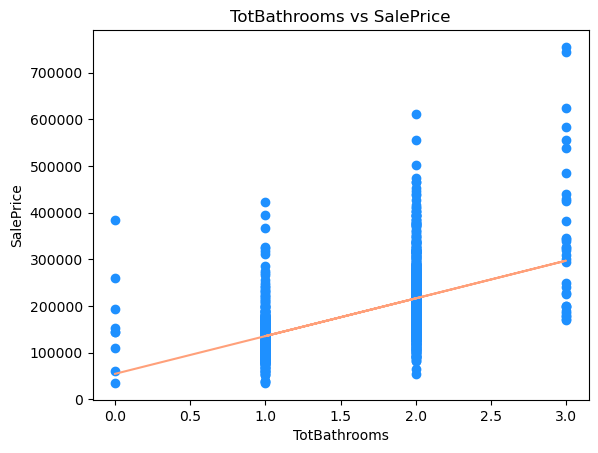

In [119]:
# Plot the linear correlation between TotBathrooms and SalePrice
plt.scatter(train_drop_df['TotBathrooms'],train_drop_df.SalePrice,color = 'dodgerblue')
model1 = np.poly1d(np.polyfit(train_drop_df['TotBathrooms'], train_drop_df.SalePrice, 1))
polyline = train_drop_df['TotBathrooms'].unique()
plt.plot(polyline, model1(polyline), color='lightsalmon')
plt.title("TotBathrooms vs SalePrice")
plt.xlabel("TotBathrooms")
plt.ylabel("SalePrice")

5.2 Total Square Feet
---

<font size=4 >As the total living space generally is very important when people buy houses, I am adding a predictors that adds up the living space above and below ground.</font>

In [120]:
# Merge columns
all_drop_df['TotalSqFeet'] = all_drop_df['GrLivArea']+all_drop_df['TotalBsmtSF']

In [121]:
# Remove unnecessary columns
all_drop_df = all_drop_df.drop(columns='GrLivArea')
all_drop_df = all_drop_df.drop(columns='TotalBsmtSF')

In [122]:
# Divide the dataset into train and test
train_drop_df = all_drop_df.loc[0:1459,:]
test_drop_df = all_drop_df.loc[1460:2918,:]

Text(0, 0.5, 'SalePrice')

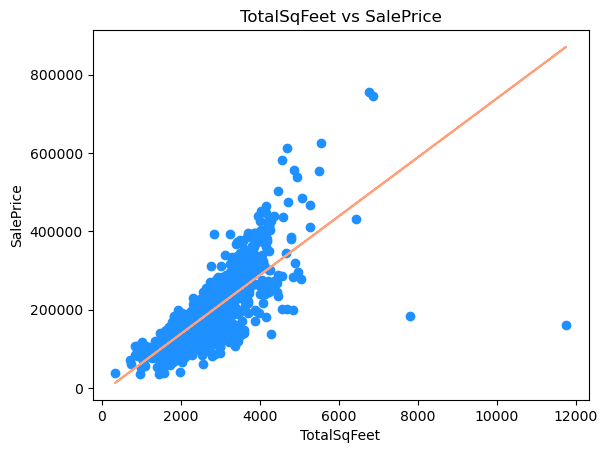

In [123]:
# Plot the linear correlation between TotBathrooms and SalePrice
plt.scatter(train_drop_df['TotalSqFeet'],train_drop_df.SalePrice,color = 'dodgerblue')
model1 = np.poly1d(np.polyfit(train_drop_df['TotalSqFeet'], train_drop_df.SalePrice, 1))
polyline = train_drop_df['TotalSqFeet'].unique()
plt.plot(polyline, model1(polyline), color='lightsalmon')
plt.title("TotalSqFeet vs SalePrice")
plt.xlabel("TotalSqFeet")
plt.ylabel("SalePrice")

5.3 Porch variables
---

<font size=4 >Below, I listed the variables that seem related regarding porches.</font>

In [124]:
# Merge columns
all_drop_df['TotalPorchSF'] = all_drop_df['OpenPorchSF']

In [125]:
# Remove unnecessary columns
all_drop_df = all_drop_df.drop(columns='OpenPorchSF')

In [126]:
# Divide the dataset into train and test
train_drop_df = all_drop_df.loc[0:1459,:]
test_drop_df = all_drop_df.loc[1460:2918,:]

Text(0, 0.5, 'SalePrice')

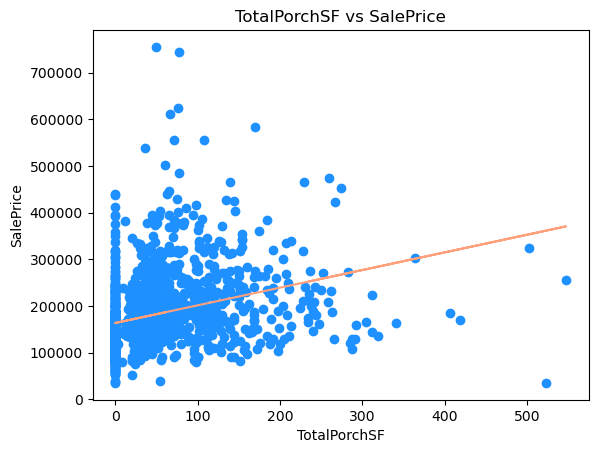

In [127]:
# Plot the linear correlation between TotBathrooms and SalePrice
plt.scatter(train_drop_df['TotalPorchSF'],train_drop_df.SalePrice,color = 'dodgerblue')
model1 = np.poly1d(np.polyfit(train_drop_df['TotalPorchSF'], train_drop_df.SalePrice, 1))
polyline = train_drop_df['TotalPorchSF'].unique()
plt.plot(polyline, model1(polyline), color='lightsalmon')
plt.title("TotalPorchSF vs SalePrice")
plt.xlabel("TotalPorchSF")
plt.ylabel("SalePrice")